# Annotation Analysis and Consensus

## Imports

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pal = sns.color_palette('Set2')[:2][::-1] + ['grey']

# OS imports
from os.path import join as ospj
from os.path import exists as ospe
import sys

# from ieeg.auth import Session # Don't need this if running from checkpoints
from utils import clean_labels, remove_scalp_electrodes, get_rpath, calculate_seizure_similarity, plot_seizure_similarity
from config import Config

# Load in the data
metapath, prodatapath, figpath = Config.deal(['metapath','prodatapath','figpath'])


## Workspace Preparation

In [2]:
# Loading seizure onset meta data
sz_metadata = pd.read_csv(ospj(metapath,'stim_seizure_information - LF_seizure_annotation.csv'))

In [3]:
def combine_ch_annots(group):
    ret = {"clinician": [],
           "patient": [],
           "ueo": [],
           "ueo_time": [],
           "sec": []
          }
    # Sorting seizure annotations by clinician
    group.sort_values(by='Clinician',inplace=True)
    # Unifying and extracting iEEG name
    group['IEEGname'] = group['IEEGname'].fillna(method='ffill').fillna(method='bfill')
    ieeg_name = group['IEEGname'].iloc[0]
    pt = group['Patient'].iloc[0]
    # Get all channels from iEEG portal
    with open('woj_ieeglogin.bin', 'r') as f:
        session = Session('wojemann', f.read())
    ds = session.open_dataset(ieeg_name)
    # Clean channel labels
    raw_labels = clean_labels(ds.get_channel_labels(),pt)
    # Remove scalp electrodes from channels
    all_chs = remove_scalp_electrodes(raw_labels)

    for _,row in group.iterrows(): # for each annotation in seizure
        for i,v in row.items(): # for each column in annotation
            if not isinstance(v,list): # filling in nan's as empty list to ensure formatting consistency
                if pd.isna(v):
                    row[i] = []
        # Adding anntotor and patient data
        ret["clinician"].append(row.Clinician)
        ret["patient"] = row.Patient
        # Adding UEO and Spread channel ifnormation
        ret["ueo"].append([l in clean_labels(row.UEO_ch,pt) for l in all_chs])
        ret["sec"].append([l in clean_labels(row["10sec_ch"],pt) for l in all_chs])
        # Adding anntotated start time
        ret["ueo_time"].append(float(row.UEO_time))
        
    # Adding in additional patient metadata to table from originnal stim seizure metadata
    ret["all_chs"] = all_chs
    ret["iEEG_ID"] = row["IEEGname"]
    ret["approximate_onset"] = row["approximate_onset"]
    ret["offset"] = row["end"]
    ret["stim"] = row["stim"]
        
    return pd.Series(ret)

def create_consensus(row):
    for key in ["ueo","sec"]:
        row[f"{key}_consensus"] = np.array(np.sum(np.array(row[key]).astype(int),axis=0) >= (len(row[key])/2)).astype(bool)
        row[f"{key}_any"] = np.array(np.sum(np.array(row[key]).astype(int),axis=0) >= 1).astype(bool)
        if key == 'ueo':
            row[f"{key}_time_consensus"] = np.median(row[f"{key}_time"])
    return row

## Creating consensus

We do not make the individual reviewer tables available as metadata, however all of the relevant annotations are available in the produced intermediate result: "threshold_tuning_consensus_v2.pkl"

In [4]:
# annotators = np.sort(['EC','CK','DZ','JJ','JK']) # annotator list
# time_labels = ['UEO_time'] # onset time label
# clinician_tables = {}
# for clin in annotators:
#     # Load in secondary annotation push
#     annot_table = pd.read_csv(ospj(metapath,f"stim_seizure_annotations_{clin}.csv"))
#     # Load in annotations from initial assessment
#     demo_table = pd.read_csv(ospj(metapath,f"stim_seizure_information - {clin}_annotation_demo.csv"))
#     # Unifying onset column name
#     demo_table.columns = [c if c != 'Onset' else 'approximate_onset' for c in demo_table.columns]
    
#     # Load in additional annotations
    
#     # Aggregating tables across clinicians and annotation sections
#     clinician_tables[clin] = []
#     clinician_tables[clin].append(annot_table)
#     clinician_tables[clin].append(demo_table)
#     if clin in ['EC','DZ']:
#         new_table = pd.read_csv(ospj(metapath,f"stim_seizure_information - {clin}_makeup.csv"))
#         new_table = new_table[["Patient","IEEGname","approximate_onset","end","stim","stim_channels","annotators","UEO_time","UEO_ch","10sec_ch"]]
#         clinician_tables[clin].append(new_table)

# # Organizing dataframes into a list for concatenation
# df_list = [df for l in clinician_tables.values() for df in l]
# # Getting annotator key for each DF
# # key_list = np.array([[key]*len(clinician_tables[key]) for key in clinician_tables.keys()]).flatten()
# key_list = np.array(list(itertools.chain.from_iterable([[key]*len(clinician_tables[key]) for key in clinician_tables.keys()])))

# # Combining DFs
# combined_df = pd.concat(df_list, keys=key_list, names=['Clinician'])

# # Reset index to avoid having MultiIndex
# combined_df.reset_index(inplace=True)

# # Drop nan rows from csv loading
# combined_df = combined_df.dropna(axis=0,how='any',subset=['UEO_ch'])

# # Create a unique identifier for each seizure
# combined_df['Seizure_ID'] = combined_df.groupby(['Patient', 'Clinician']).cumcount() + 1
# combined_df['Seizure_ID'] = combined_df['Patient'] + '_' + combined_df['Seizure_ID'].astype(int).astype(str)
# combined_df = combined_df.drop(['level_1'],axis=1)

# # Turning strings of channels to a list
# combined_df['UEO_ch'] = combined_df['UEO_ch'].str.split(',')
# combined_df['10sec_ch'] = combined_df['10sec_ch'].str.split(',')

In [5]:
# combined_tuning_annots = combined_df.groupby('Seizure_ID').apply(combine_ch_annots).reset_index()
# # combined_tuning_annots.to_pickle(ospj(prodatapath,'raw_combined_clinician_annotations.pkl'))
# # combined_tuning_annots = pd.read_pickle(ospj(prodatapath,'raw_combined_clinician_annotations.pkl'))
# consensus_tuning_annots = combined_tuning_annots.apply(create_consensus,axis=1)
# consensus_tuning_annots.to_pickle(ospj(prodatapath,"threshold_tuning_consensus_v2.pkl"))
consensus_tuning_annots = pd.read_pickle(ospj(prodatapath,"threshold_tuning_consensus_v2.pkl"))
consensus_tuning_annots.patient.unique()

array(['CHOP005', 'CHOP010', 'CHOP015', 'CHOP024', 'CHOP026', 'CHOP028',
       'CHOP035', 'CHOP037', 'CHOP038', 'CHOP041', 'CHOP044', 'CHOP045',
       'CHOP046', 'CHOP049', 'HUP224', 'HUP225', 'HUP229', 'HUP230',
       'HUP235', 'HUP238', 'HUP246', 'HUP247', 'HUP249', 'HUP250',
       'HUP253', 'HUP257', 'HUP261', 'HUP263', 'HUP266', 'HUP267',
       'HUP273', 'HUP275', 'HUP288'], dtype=object)

## Manual annotation analysis

In [6]:
consensus_annots = pd.read_pickle(ospj(prodatapath,"threshold_tuning_consensus_v2.pkl"))
consensus_annots = consensus_annots.sort_values('approximate_onset')
seizures_df = pd.read_csv(ospj(metapath,"stim_seizure_information - LF_seizure_annotation.csv"))
seizures_df.dropna(axis=0,how='all',inplace=True)
seizures_df.rename(columns=dict(Patient='patient',IEEGname='iEEG_ID'),inplace=True)
seizures_df['approximate_onset'].fillna(seizures_df['UEO'],inplace=True)
seizures_df['approximate_onset'].fillna(seizures_df['EEC'],inplace=True)
seizures_df['approximate_onset'].fillna(seizures_df['Other_onset_description'],inplace=True)
# drop HF stim induced seizures from patients with both HF and LF stim
seizures_df = seizures_df[seizures_df.stim != 2]
seizures_df.sort_values('approximate_onset',inplace=True)

In [7]:
consensus_annots = pd.merge_asof(consensus_annots,
            seizures_df[['approximate_onset','patient',"iEEG_ID","typical","stim_channels"]],
            on='approximate_onset',by=['patient','iEEG_ID'],
            tolerance = 240, # Include a tolerance for small variations in onset time between metadata sources
            direction='nearest')

### Channels

#### Stim seizures localizing onset

Skipped ['CHOP005', 'CHOP010', 'CHOP015', 'CHOP024', 'CHOP026', 'CHOP028', 'CHOP035', 'CHOP037', 'CHOP038', 'CHOP041', 'CHOP044', 'CHOP045', 'CHOP046', 'CHOP049', 'HUP229', 'HUP246', 'HUP261', 'HUP267', 'HUP273', 'HUP275', 'HUP288'] due to insufficient spontaneous seizures
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Wilcoxon test (paired samples), P_val:5.371e-02 Stat=1.100e+01
Spontaneous: N = 12 1.00 [1.00, 1.00]
Stim: N = 12 0.59 [0.37, 0.85]


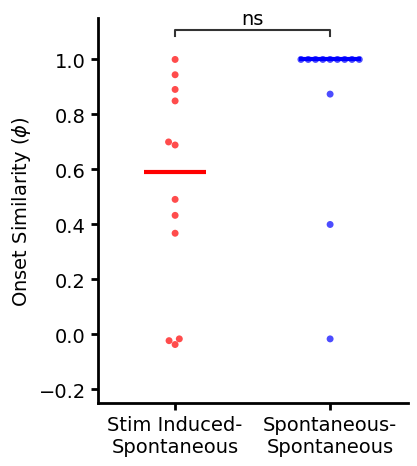

In [8]:
channel_onset_df = calculate_seizure_similarity(consensus_annots)
agreement='MCC'
_ = plot_seizure_similarity(channel_onset_df,annot_type=' Onset',sz_level=False)
plt.savefig(ospj(figpath,"figure_S2_A.pdf"),bbox_inches='tight')

### Regions

#### Annotating Onsets

In [9]:
pt_groups = consensus_annots.groupby('patient')
for pt,group in pt_groups:
    region_path = get_rpath(prodatapath,pt)
    if not ospe(region_path):
        continue
    electrode_regions = pd.read_pickle(region_path)
    # electrode_regions = surgical_parcellation(electrode_regions)
    for idx,row in group.iterrows():
        consensus_annots.at[idx,'all_rs'] = np.array(electrode_regions[electrode_regions.name.isin(row['all_chs'])]['label'].unique())
        for col in ['ueo_consensus','ueo_any','sec_consensus','sec_any']:
            chs = np.array(row.all_chs)[row[col]]
            electrode_locals = np.array([l for l in electrode_regions[electrode_regions.name.isin(chs)]['label'].unique() if l != 'EmptyLabel'])
            consensus_annots.at[idx,col+'_rs'] = np.array([l in electrode_locals for l in consensus_annots.loc[idx,'all_rs']])
consensus_annots_rs = consensus_annots.dropna(axis=0,subset='ueo_consensus_rs')
consensus_annots_rs.sort_values(['patient','iEEG_ID','approximate_onset'],inplace=True)

Skipped ['CHOP005', 'CHOP010', 'CHOP015', 'CHOP024', 'CHOP026', 'CHOP028', 'CHOP035', 'CHOP037', 'CHOP041', 'CHOP044', 'CHOP045', 'CHOP049', 'HUP229', 'HUP246', 'HUP261', 'HUP267', 'HUP273', 'HUP275', 'HUP288'] due to insufficient spontaneous seizures
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Wilcoxon test (paired samples), P_val:3.750e-01 Stat=8.000e+00
Spontaneous: N = 12 1.00 [0.68, 1.00]
Stim: N = 12 0.69 [0.00, 1.00]


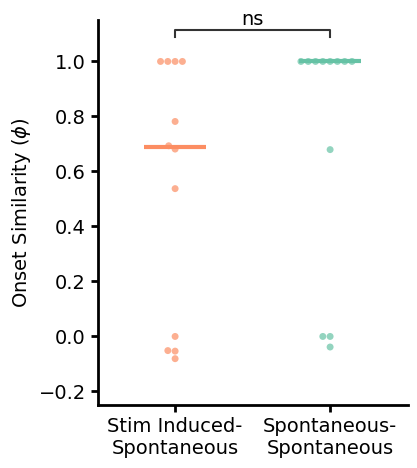

In [10]:
channel_onset_df = calculate_seizure_similarity(consensus_annots_rs,first_annot='ueo_consensus_rs',second_annot='ueo_consensus_rs')
_ = plot_seizure_similarity(channel_onset_df,annot_type=' Onset',palette=pal,agreement='MCC',sz_level=False)
plt.savefig(ospj(figpath,"figure_S2_B.pdf"),bbox_inches='tight')